# CIFAR 10 Image Classifier

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import datetime
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
print(torch.version.cuda)

Using cuda device
11.6


## Getting Data

Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


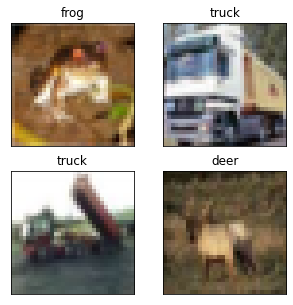

In [2]:
data_viz = torchvision.datasets.CIFAR10(root="./data", download="true")

print(data_viz.classes)

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5,5))

for i in range(4):
    ax1 = fig.add_subplot(2,2,i+1)
    ax1.set_title(data_viz.classes[data_viz[i][1]])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.imshow(data_viz[i][0])

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(root="./data", download="true", train=True, transform = transform)
testset = torchvision.datasets.CIFAR10(root="./data", download="true", train=False, transform = transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True, pin_memory=True, num_workers=2)
testloader = DataLoader(testset, batch_size=64, shuffle=False, pin_memory=True, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


## Building Model

In [4]:
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)
        
        self.bnfc = nn.BatchNorm1d(128)
        
        self.dropout1 = nn.Dropout2d(0.3)
        self.dropout2 = nn.Dropout2d(0.5)
        self.dropout3 = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):

        x = self.bn1(F.relu(self.conv1(x)))   
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.dropout1(self.pool(x))
        
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.dropout2(self.pool(x))       
        
        x = self.bn5(F.relu(self.conv5(x)))
        x = self.bn6(F.relu(self.conv6(x)))
        x = self.dropout2(self.pool(x))
        
        x = torch.flatten(x, 1)
        x = self.bnfc(F.relu(self.fc1(x)))
        x = self.dropout3(x)
        x = self.fc2(x)
        
        return x
    
net = Net().to(device)

Using cuda device


In [5]:
from torchsummary import summary
summary(net, (3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 32, 32]          896
├─BatchNorm2d: 1-2                       [-1, 32, 32, 32]          64
├─Conv2d: 1-3                            [-1, 32, 32, 32]          9,248
├─BatchNorm2d: 1-4                       [-1, 32, 32, 32]          64
├─MaxPool2d: 1-5                         [-1, 32, 16, 16]          --
├─Dropout2d: 1-6                         [-1, 32, 16, 16]          --
├─Conv2d: 1-7                            [-1, 64, 16, 16]          18,496
├─BatchNorm2d: 1-8                       [-1, 64, 16, 16]          128
├─Conv2d: 1-9                            [-1, 64, 16, 16]          36,928
├─BatchNorm2d: 1-10                      [-1, 64, 16, 16]          128
├─MaxPool2d: 1-11                        [-1, 64, 8, 8]            --
├─Dropout2d: 1-12                        [-1, 64, 8, 8]            --
├─Conv2d: 1-13                           [-1, 128, 8, 8]           73,8

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 32, 32]          896
├─BatchNorm2d: 1-2                       [-1, 32, 32, 32]          64
├─Conv2d: 1-3                            [-1, 32, 32, 32]          9,248
├─BatchNorm2d: 1-4                       [-1, 32, 32, 32]          64
├─MaxPool2d: 1-5                         [-1, 32, 16, 16]          --
├─Dropout2d: 1-6                         [-1, 32, 16, 16]          --
├─Conv2d: 1-7                            [-1, 64, 16, 16]          18,496
├─BatchNorm2d: 1-8                       [-1, 64, 16, 16]          128
├─Conv2d: 1-9                            [-1, 64, 16, 16]          36,928
├─BatchNorm2d: 1-10                      [-1, 64, 16, 16]          128
├─MaxPool2d: 1-11                        [-1, 64, 8, 8]            --
├─Dropout2d: 1-12                        [-1, 64, 8, 8]            --
├─Conv2d: 1-13                           [-1, 128, 8, 8]           73,8

## Training Model

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),eps=1e-07)

def train(dataloader, model, loss_fn, optimizer, out=False):
    model.train()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    correct, train_loss = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        bs = X.shape[0]
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)
        
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch == num_batches-1:
            correct /= size
            train_loss /= num_batches
            if out == True:
                print(f"Train Error: \n  Accuracy: {(100*correct):>0.1f}% Loss: {train_loss:>4f}")

 

In [7]:
losses = []
def test(dataloader, model, loss_fn, out=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    losses.append(test_loss)
    if out == True:
        print(f"Test Error: \n  Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:
start = datetime.datetime.now()
epochs = 100
for t in range(epochs):
    if (t+1) % 10 == 0 or t == 0:
        print(f"Epoch {t+1}\n-------------------------------")
        train(trainloader, net, criterion, optimizer, True)
        test(testloader, net, criterion, True)
    else:
        train(trainloader, net, criterion, optimizer)
        test(testloader, net, criterion)
    
print("Done!")
end = datetime.datetime.now()
print(end-start)

Epoch 1
-------------------------------
Train Error: 
  Accuracy: 41.1% Loss: 1.609617
Test Error: 
  Accuracy: 56.0%, Avg loss: 1.195972 

Epoch 10
-------------------------------
Train Error: 
  Accuracy: 74.3% Loss: 0.748985
Test Error: 
  Accuracy: 79.2%, Avg loss: 0.609118 

Epoch 20
-------------------------------
Train Error: 
  Accuracy: 79.4% Loss: 0.607053
Test Error: 
  Accuracy: 82.3%, Avg loss: 0.525537 

Epoch 30
-------------------------------
Train Error: 
  Accuracy: 81.8% Loss: 0.533280
Test Error: 
  Accuracy: 83.6%, Avg loss: 0.491145 

Epoch 40
-------------------------------
Train Error: 
  Accuracy: 83.5% Loss: 0.484179
Test Error: 
  Accuracy: 84.6%, Avg loss: 0.470213 

Epoch 50
-------------------------------
Train Error: 
  Accuracy: 84.7% Loss: 0.444012
Test Error: 
  Accuracy: 84.5%, Avg loss: 0.466200 

Epoch 60
-------------------------------
Train Error: 
  Accuracy: 85.3% Loss: 0.422243
Test Error: 
  Accuracy: 85.0%, Avg loss: 0.460879 

Epoch 70
-----

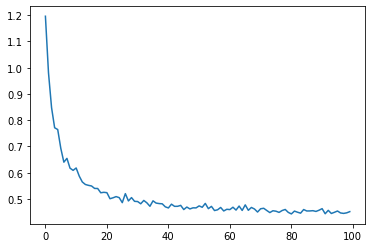

In [9]:
plt.plot(losses)
plt.show()

## Predictions

1 dog
2 cat
3 bird


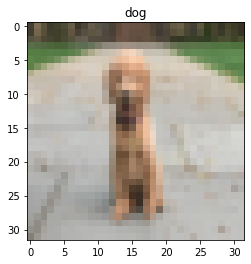

In [10]:
from PIL import Image

im = Image.open("doggy.jpg") 
  
trans = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor()
])
check = trans(im)
check = check.reshape(1,3,32,32)
check = check.to(device)

net.eval()
outs = net(check)

top3 = torch.topk(outs[0], 3).indices

    
im = transforms.Resize((32,32))(im)
plt.title(testloader.dataset.classes[outs.argmax(1)])
plt.imshow(im)

for i in range(3):
    print(i+1, testloader.dataset.classes[top3[i].item()])

In [11]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)